+ 작성자: 최현승
+ 최종 작성일: 2018-03-26
+ 작성내용:Data Analytics
    1. Data Preprocessing
    2. Data Analytics
+ 데이터: 
    + train,test data set으로 구분된 NSL-KDD(전처리됨)
        + 입력데이터: 수치형데이터 + binary 데이터 + 카테고리 데이터
        + data/df_train = 전체데이터의 85%를 정상/비정상 99:1 비중으로 조절 
        + data/df_test = 전체데이터의 15%
        + 원본: NSL-KDD http://www.unb.ca/cic/datasets/nsl.html

In [1]:
model_name ='AE_Train1'

In [2]:
import pandas as pd
import numpy as np
import sys
import tensorflow as tf

# 1. Data Preprocessing

In [3]:
# Data Import 
df_train = pd.read_csv('data/df_train1(preprocessed).csv')
df_test = pd.read_csv('data/df_test(preprocessed).csv')

In [4]:
# 수치형 변수 리스트
numeric_fields = ['duration', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']

# 부울형 변수 리스트 
binary_fields = ['land', 'logged_in', 'is_host_login','is_guest_login']

# 카테고리형 변수 리스트
category_fields = ['protocol_type1', 'protocol_type2', 'protocol_type3',
                   'service1', 'service2', 'service3', 'service4', 'service5',
                   'service6', 'service7', 'service8', 'service9', 'service10',
                   'service11', 'service12', 'service13', 'service14', 'service15',
                   'service16', 'service17', 'service18', 'service19', 'service20',
                   'service21', 'service22', 'service23', 'service24', 'service25',
                   'service26', 'service27',
                   'flag1', 'flag2', 'flag3', 'flag4', 'flag5',
                   'flag6', 'flag7', 'flag8', 'flag9']

total_fields = numeric_fields + binary_fields + category_fields

In [5]:
# numpy.array로 변환 
X_train = np.array(df_train[total_fields])

X_train_inputs, X_train_labels = \
                            np.array(df_train[total_fields]), np.array(df_train['attack_type'])
    
X_test_inputs, X_test_labels = \
                            np.array(df_test[total_fields]), np.array(df_test['attack_type'])
X_test_total = np.append(X_test_inputs, X_test_labels.reshape(-1,1), axis=1)  

# 2. Data Analyatics

## 2.1 Autoendoer

In [6]:
from analytics_module import * 

### Atutoencoder Training

In [7]:
from functools import partial

n_inputs = X_train.shape[1]
n_hidden1 = 32
n_outputs = n_inputs

# 0.01 ~ 0.001 사이 
learning_rate = 0.0001
l2_reg = 0.01

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.relu,
    kernel_initializer=initializer,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)
)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
logits = my_dense_layer(hidden1, n_outputs, activation=None)
outputs = tf.sigmoid(logits)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=1000)

import pickle
recon_errors = []

n_epochs = 51
batch_size = 256

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

num_examples = X_train.shape[0]

In [ ]:


for epoch in range(n_epochs):
    n_batches = num_examples // batch_size
    for iteration in range(n_batches):
        #print("\r{}%".format(100 * iteration // n_batches), end="")
        sys.stdout.flush()
        X_batch = next_batch(batch_size, X_train)
        sess.run(training_op, feed_dict={X: X_batch})
    reconstruction_loss_val = sess.run(reconstruction_loss, feed_dict={X: X_batch})
    recon_errors.append(reconstruction_loss_val)
    
    if epoch % 5 == 0 :
        model_save_dir = './my_test_model/' + model_name+ '/l2_reg'+ str(l2_reg)+ '/learing_rate' + str(learning_rate) + '/epoch' + str(epoch)
        print("model save : ",model_save_dir)
        saver.save(sess, model_save_dir)
        
    if epoch % 10 == 0:
        print("\r{}".format(epoch), "Train loss:", reconstruction_loss_val)
    
    
 # cost list save
cost_dir = './cost_list/' + model_name+ '/l2_reg'+ str(l2_reg) + '/learning_rate' + str(learning_rate) + '_epoch' + str(epoch)  
with open(cost_dir+'total_errors.pkl', 'wb') as f:
    pickle.dump(recon_errors, f)

In [ ]:
import matplotlib.pyplot as plt
epoch = n_epochs - 1
cost_dir = './cost_list/' + model_name+ '/l2_reg'+ str(l2_reg) + '/learning_rate' + str(learning_rate) + '_epoch' + str(epoch) 

import pickle
with open(cost_dir+'total_errors.pkl', 'rb') as f:
    recon_errors = pickle.load(f)

plt.plot(recon_errors, label='error')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Autoencoder Test

In [8]:
# model restore
#learning_rate = 0.005
#le_reg  0.0001
epoch = 10

model_save_dir = './my_test_model/' + model_name+ '/l2_reg'+ str(l2_reg)+ '/learing_rate' + str(learning_rate) + '/epoch' + str(epoch)
saver.restore(sess, model_save_dir)

INFO:tensorflow:Restoring parameters from ./my_test_model/AE_Train1/l2_reg0.01/learing_rate0.0001/epoch10


In [9]:
# Reconstruction Error Threshold 계산
input_data = X_train_inputs
output_data = sess.run(outputs, feed_dict={X: input_data})
total_data = X_train

df_performance = get_df_performance(input_data=input_data, output_data=output_data, total_data=total_data)

train_error = df_performance['error']
mu, sigma = error_statistics_check(train_error)

# 1%: mu + 2.33 * sigma
# 5%: mu + 1.645 * sigma
# 10%: mu + 1.28 * sigma 

threshold_1 = mu + (2.33 * sigma)
threshold_5 = mu + (1.645 * sigma)
threshold_10 = mu + (1.28 * sigma)
threshold_50 = mu

print("threshold_1=%f, threshold_5=%f, threshold_10=%f, threshold_50=%f"%(threshold_1, threshold_5, threshold_10, threshold_50))

# Test dataset으로 검증 
input_data = X_test_inputs
output_data = sess.run(outputs, feed_dict={X: input_data})
total_data = X_test_total

df_performance = get_df_performance(input_data=input_data, output_data=output_data, total_data=total_data)
performance_check(threshold = threshold_1, df = df_performance)

mu=0.794527, sigma=0.434251
threshold_1=1.806331, threshold_5=1.508869, threshold_10=1.350368, threshold_50=0.794527
tn:11394.00000, fp:215.00000, fn:1635.00000, tp:9034.00000, total:.22278.000000
accuracy: 0.91696, f1_score: 0.90712
sensitivity : 0.84675, specificity : 0.98148
precision : 0.97675, recall : 0.84675


# Visualization

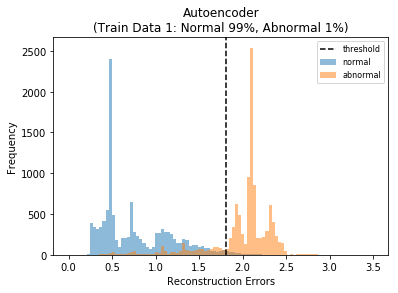

In [31]:
import numpy
import matplotlib.pyplot as plt
# test 
normal_error = df_performance[df_performance['attack_types'] == 'normal']['error']
abnormal_error = df_performance[df_performance['attack_types'] == 'abnormal']['error']

fig = plt.figure()
bins = numpy.linspace(0, 3.5, 100)

plt.title('Autoencoder\n(Train Data 1: Normal 99%, Abnormal 1%)')
plt.xlabel('Reconstruction Errors')
plt.ylabel('Frequency')
plt.axvline(x=threshold_1, color='black', linestyle='dashed', label='threshold')
plt.hist(normal_error, bins, alpha=0.5, label='normal')
plt.hist(abnormal_error, bins, alpha=0.5, label='abnormal')
plt.legend(loc='upper right', prop={'size': 8})
plt.show()
fig.savefig(model_save_dir+'.png')